In [1]:
import deeplabcut as dlc
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

Loading DLC 3.0.0rc8...


In [3]:
DATA_DIR = "/Users/saffirayantjon/Documents/DLC/OCNC_DLC_Tutorial/output/"

DATA_FILE:h5py.File = h5py.File (DATA_DIR+"M_190124_110324_12_60fpsDLC_resnet50_OCNCJun19shuffle1_15000.h5", 'r')

In [4]:
df = pd.read_hdf(DATA_DIR+"M_190124_110324_12_60fpsDLC_resnet50_OCNCJun19shuffle1_15000.h5")
df.head()

scorer    DLC_resnet50_OCNCJun19shuffle1_15000                         \
bodyparts                                  LFP                          
coords                                       x           y likelihood   
0                                   430.097412  320.717590   0.482372   
1                                   421.295319  320.654877   0.199501   
2                                   413.740753  318.292542   0.592182   
3                                   367.900879  397.376740   0.593363   
4                                   358.745117  395.708191   0.929618   

scorer                                                                \
bodyparts         RFP                                LHP               
coords              x           y likelihood           x           y   
0          414.833344  401.897461   0.184540  436.928406  314.637756   
1          390.110107  400.433136   0.309973  415.652802  314.662689   
2          378.824249  397.860565   0.457562  411.524048  313.549866   
3          368.354858  398.006104   0.457022  210.707733  208.780197   
4          358.666412  395.231873   0.100264  354.527008  393.703064   

scorer                            ...                                     \
bodyparts                    RHP  ...                     TB               
coords    likelihood           x  ... likelihood           x           y   
0           0.272341  191.963287  ...   0.959877  101.009308  315.822723   
1           0.675203  198.679749  ...   0.989191  109.208145  304.384033   
2           0.249006  191.950912  ...   0.989225  160.988281  320.553650   
3           0.126415  184.256500  ...   0.973990  120.973572  274.298004   
4           0.079532  181.365219  ...   0.984865  121.557938  257.156372   

scorer                                                              \
bodyparts                    T0                                  N   
coords    likelihood          x           y likelihood           x   
0           0.935860  49.467484  306.716431   0.725726  612.187378   
1           0.793388  61.685154  293.916473   0.647473  608.325806   
2           0.524949  96.500526  284.542389   0.555938  612.665161   
3           0.883380  64.184784  256.763702   0.813769  609.282776   
4           0.935283  69.000801  244.602661   0.591748  609.287964   

scorer                            
bodyparts                         
coords              y likelihood  
0          355.142120   0.997634  
1          356.984924   0.998671  
2          356.692627   0.994401  
3          355.319061   0.999518  
4          353.786926   0.999055  

[5 rows x 21 columns]

In [5]:
def df_bodypart(df, bodypart):
    """
    Dataframe per bodypart
    -------------------------
    :param df: Pandas DF
    :param bodypart: string of bodypart (dlc label)
    :return: Pandas DF
    """
    scorer = list (df.columns.get_level_values ('scorer'))[0]
    df_bodypart = df.xs (bodypart, level='bodyparts', axis=1)
    df_bodypart = df_bodypart.xs (scorer, level='scorer', axis=1)
    return df_bodypart

def frames_array(df, fps=None):
    """
    Create time vector (s) based on fps
    ----------------------------------
    :param dataframe:
    :param fps: frames per second from video acquisition
    :return:
    """
    time = 1
    if isinstance(fps, int): # check if inputted fps is integer
        time=fps
    return np.array (list (df.index))/time

class LabelArray:
    def __init__(self, df, label, thresh=0.99):
        # raw video x,y pixel coordinates
        xdata = df_bodypart(df, label)["x"].values
        ydata = df_bodypart(df, label)["y"].values
        likelihood = df_bodypart(df, label)["likelihood"].values

        xdata[likelihood < thresh], ydata[likelihood < thresh] = np.nan, np.nan

        self.x = np.array(xdata)
        self.y = np.array(ydata)
        self.time = frames_array(df, fps=60)

In [6]:
labels = list (df.columns.get_level_values ('bodyparts'))
labels = list(dict.fromkeys(labels))
labels 

['LFP', 'RFP', 'LHP', 'RHP', 'TB', 'T0', 'N']

In [7]:
for key in labels:
    fig = px.scatter(df_bodypart(df, key), x="x", y="y", color='likelihood')
    print(key)
    fig.show()

LFP


RFP


LHP


RHP


TB


T0


N


In [8]:
labelarrays = {}
THRESH = 0.8
for label in labels:
    array = LabelArray(df=df, label=label,thresh=THRESH)
    labelarrays.update({label:array})
labelarrays   

{'LFP': <__main__.LabelArray at 0x33c77c610>,
 'RFP': <__main__.LabelArray at 0x11605d900>,
 'LHP': <__main__.LabelArray at 0x33b20b2b0>,
 'RHP': <__main__.LabelArray at 0x11605ca30>,
 'TB': <__main__.LabelArray at 0x11605d840>,
 'T0': <__main__.LabelArray at 0x11605d510>,
 'N': <__main__.LabelArray at 0x33b20bd60>}

In [10]:
fig = go.Figure()
for key, value in labelarrays.items():
    fig.add_trace(go.Scatter(x=value.x, y=value.y,
                             mode="markers",
                             name=key
                )
    )
fig.update_layout(title="Where is my data? OwO", 
                  xaxis_title="x [px]",yaxis_title="y [px]")
fig.show()

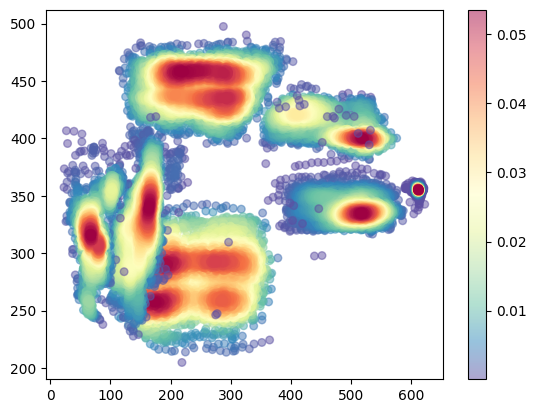

In [11]:
from scipy.stats import gaussian_kde
import matplotlib
import collections

fig = plt.figure()

for key,value in labelarrays.items():
      xy = np.array([value.x, value.y])

      if np.any(np.isnan(xy)):
            xy = xy[:,~np.isnan(xy).any(axis=0)]

      z = gaussian_kde(xy)(xy)
      density_idx = z.argsort()

      x_, y_, z_ = xy[0][density_idx], xy[1][density_idx], z[density_idx]
      # plot density of cluster and cax, for colorbar
      plt.scatter(x=x_, y=y_, c=z_, 
                        s=30,cmap=plt.cm.Spectral_r,alpha=0.5
      )
plt.colorbar()
plt.show()

In [12]:
fig = go.Figure()
for key, value in labelarrays.items():
    fig.add_trace(go.Scatter(x=value.time, y=value.x,
                             mode="lines",
                             name=key
                )
    )
fig.update_layout(title="Where is my data? OwO", 
                  xaxis_title="Time [s]",yaxis_title="x position [px]")
fig.show()

In [13]:
def fill_nan(array):
    from scipy import interpolate
    """
    interpolate the NAN values of an array
    :param array: 1D array
    :return: 1D array with interpolated former NAN values
    """
    idx = np.arange(array.shape[0])
    good = np.where(np.isfinite(array))
    interp = interpolate.interp1d(idx[good], array[good], bounds_error=False)
    return np.where(np.isfinite(array), array, interp(idx))

In [14]:
fig = go.Figure()
for key, value in labelarrays.items():
    fig.add_trace(go.Scatter(x=value.time, y=fill_nan(value.x),
                             mode="lines",
                             name=key
                )
    )
fig.update_layout(title="Interpolated NaN", 
                  xaxis_title="Time [s]",yaxis_title="x position [px]")
fig.show()

In [16]:
fig = go.Figure()
for key, value in labelarrays.items():
    if "T" in key:
        fig.add_trace(go.Scatter(x=value.time, y=fill_nan(value.y),
                                mode="lines",
                                name=key
                    )
        )
fig.update_layout(title="Tail movement", 
                  xaxis_title="Time [s]",yaxis_title="y position [px]")
fig.show()